The goal of this notebook is to determine if ISM * dosage concords well with Enformer (baseline or finetuned)
predictions. If the concordance is high, this indicates that the model is making a linear prediction based on the
dosages. We hypothesize that after finetuning the concordance will decrease.

In [3]:
import importlib
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm

sys.path.append("/data/yosef3/users/ruchir/finetuning-enformer/predixcan_lite")
import utils

sys.path.append("..")
import evaluation_utils

importlib.reload(evaluation_utils)

<module 'evaluation_utils' from '/data/yosef3/users/ruchir/finetuning-enformer/analysis/ISM/../evaluation_utils.py'>

In [4]:
COUNTS_PATH = "/data/yosef3/users/ruchir/finetuning-enformer/process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
FINETUNED_CLASSIFICATION_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/classification_rep0_scheduler_rcprob_0.5_rsmax_3/ism"
FINETUNED_CLASSIFICATION_PREDS = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/classification_rep0_scheduler_rcprob_0.5_rsmax_3/preds/test_preds.npz"
SEQLEN = 384 * 128

In [5]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")
preds_df = evaluation_utils.load_finetuned_model_predictions(
    FINETUNED_CLASSIFICATION_PREDS
)

In [12]:
pearsons_per_gene = {}
spearmans_per_gene = {}
ism_x_dosages_df = preds_df.copy()

for gene in tqdm(preds_df.index):
    gene_preds = preds_df.loc[gene].dropna()
    samples = gene_preds.index.tolist()
    assert (
        len(samples) == 77 or len(samples) == 421
    )  # 77 for random/population split, 421 for unseen genes

    genotype_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"], counts_df.loc[gene, "Coord"], SEQLEN
    )  # (variants, samples)
    genotype_mtx = genotype_mtx.loc[:, samples]
    dosage_mtx = utils.convert_to_dosage_matrix(genotype_mtx)  # (variants, samples)
    dosage_mtx.index = [str(v) for v in dosage_mtx.index]

    gene_ism_df = pd.read_csv(
        os.path.join(FINETUNED_CLASSIFICATION_ISM_DIR, f"{gene}.csv"), index_col=0
    )
    variants = gene_ism_df.index.tolist()
    isms = gene_ism_df["ISM"].to_numpy()  # (variants,)
    assert isms.size == 0 or ~np.isnan(isms).any()

    # Check that the variants in the dosage matrix that we do not have ISM scores for have AC = 0
    assert set(variants).issubset(set(dosage_mtx.index))
    for variant in set(dosage_mtx.index) - set(variants):
        assert dosage_mtx.loc[variant].sum() == 0

    dosages = dosage_mtx.loc[variants].to_numpy().T  # (samples, variants)
    ism_x_dosages = dosages @ isms

    pearson = pearsonr(gene_preds.to_numpy(), ism_x_dosages)[0]
    spearman = spearmanr(gene_preds.to_numpy(), ism_x_dosages)[0]

    pearsons_per_gene[gene] = pearson if not np.isnan(pearson) else 0.0
    spearmans_per_gene[gene] = spearman if not np.isnan(spearman) else 0.0
    ism_x_dosages_df.loc[gene, samples] = ism_x_dosages

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_2050806/4053571345.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = pearsonr(gene_preds.to_numpy(), ism_x_dosages)[0]
/tmp/ipykernel_2050806/4053571345.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(gene_preds.to_numpy(), ism_x_dosages)[0]


In [13]:
def compute_pearson_correlations_with_ground_truth(
    df1: pd.DataFrame, df2: pd.DataFrame
) -> dict[str, float]:
    """
    For metric == r2_score, df1 should contain the true values and df2 the predictions.
    """
    common_genes = df1.index.intersection(df2.index)
    correlations = {}
    for g in tqdm(common_genes):
        df1_samples = df1.loc[g].dropna().index
        df2_samples = df2.loc[g].dropna().index
        common_samples = df1_samples.intersection(df2_samples)
        assert len(common_samples) == 77 or len(common_samples) == 421
        corr, _ = pearsonr(df1.loc[g, common_samples], df2.loc[g, common_samples])
        correlations[g] = corr if not np.isnan(corr) else 0.0
    return correlations

In [14]:
def plot_correlation_comparison(
    corrs1: dict[str, float],
    corrs2: dict[str, float],
    ax: plt.Axes,
    xlabel: str,
    ylabel: str,
    title: str,
    genes: list[str] = None,
):
    if genes is None:
        genes = list(corrs1.keys() & corrs2.keys())
    else:
        assert set(genes).issubset(corrs1.keys() & corrs2.keys())

    corrs1_l = [corrs1[g] for g in genes]
    corrs2_l = [corrs2[g] for g in genes]
    sns.scatterplot(x=corrs1_l, y=corrs2_l, ax=ax)
    ax.set_xlabel(xlabel + "\n" + rf"($\mu$ = {np.mean(corrs1_l):.3f})", fontsize=15)
    ax.set_ylabel(ylabel + "\n" + rf"($\mu$ = {np.mean(corrs2_l):.3f})", fontsize=15)
    ax.set_title(title, fontsize=18)

    # Draw y = x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Add text for number of genes where corrs1 > corrs2 and vice versa
    n_corrs1_better = sum(c1 > c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    n_corrs2_better = sum(c1 <= c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    ax.text(
        0.83, 0.05, f"{n_corrs1_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )
    ax.text(
        0.05, 0.95, f"{n_corrs2_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )

In [15]:
original_finetuned_corrs = compute_pearson_correlations_with_ground_truth(
    counts_df, preds_df
)
linearized_finetuned_corrs = compute_pearson_correlations_with_ground_truth(
    counts_df, ism_x_dosages_df
)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_2050806/167666574.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df1.loc[g, common_samples], df2.loc[g, common_samples])


  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
random_split_genes = [
    g for g in gene_to_class_map if gene_to_class_map[g] == "random_split"
]
population_split_genes = [
    g for g in gene_to_class_map if gene_to_class_map[g] == "yri_split"
]

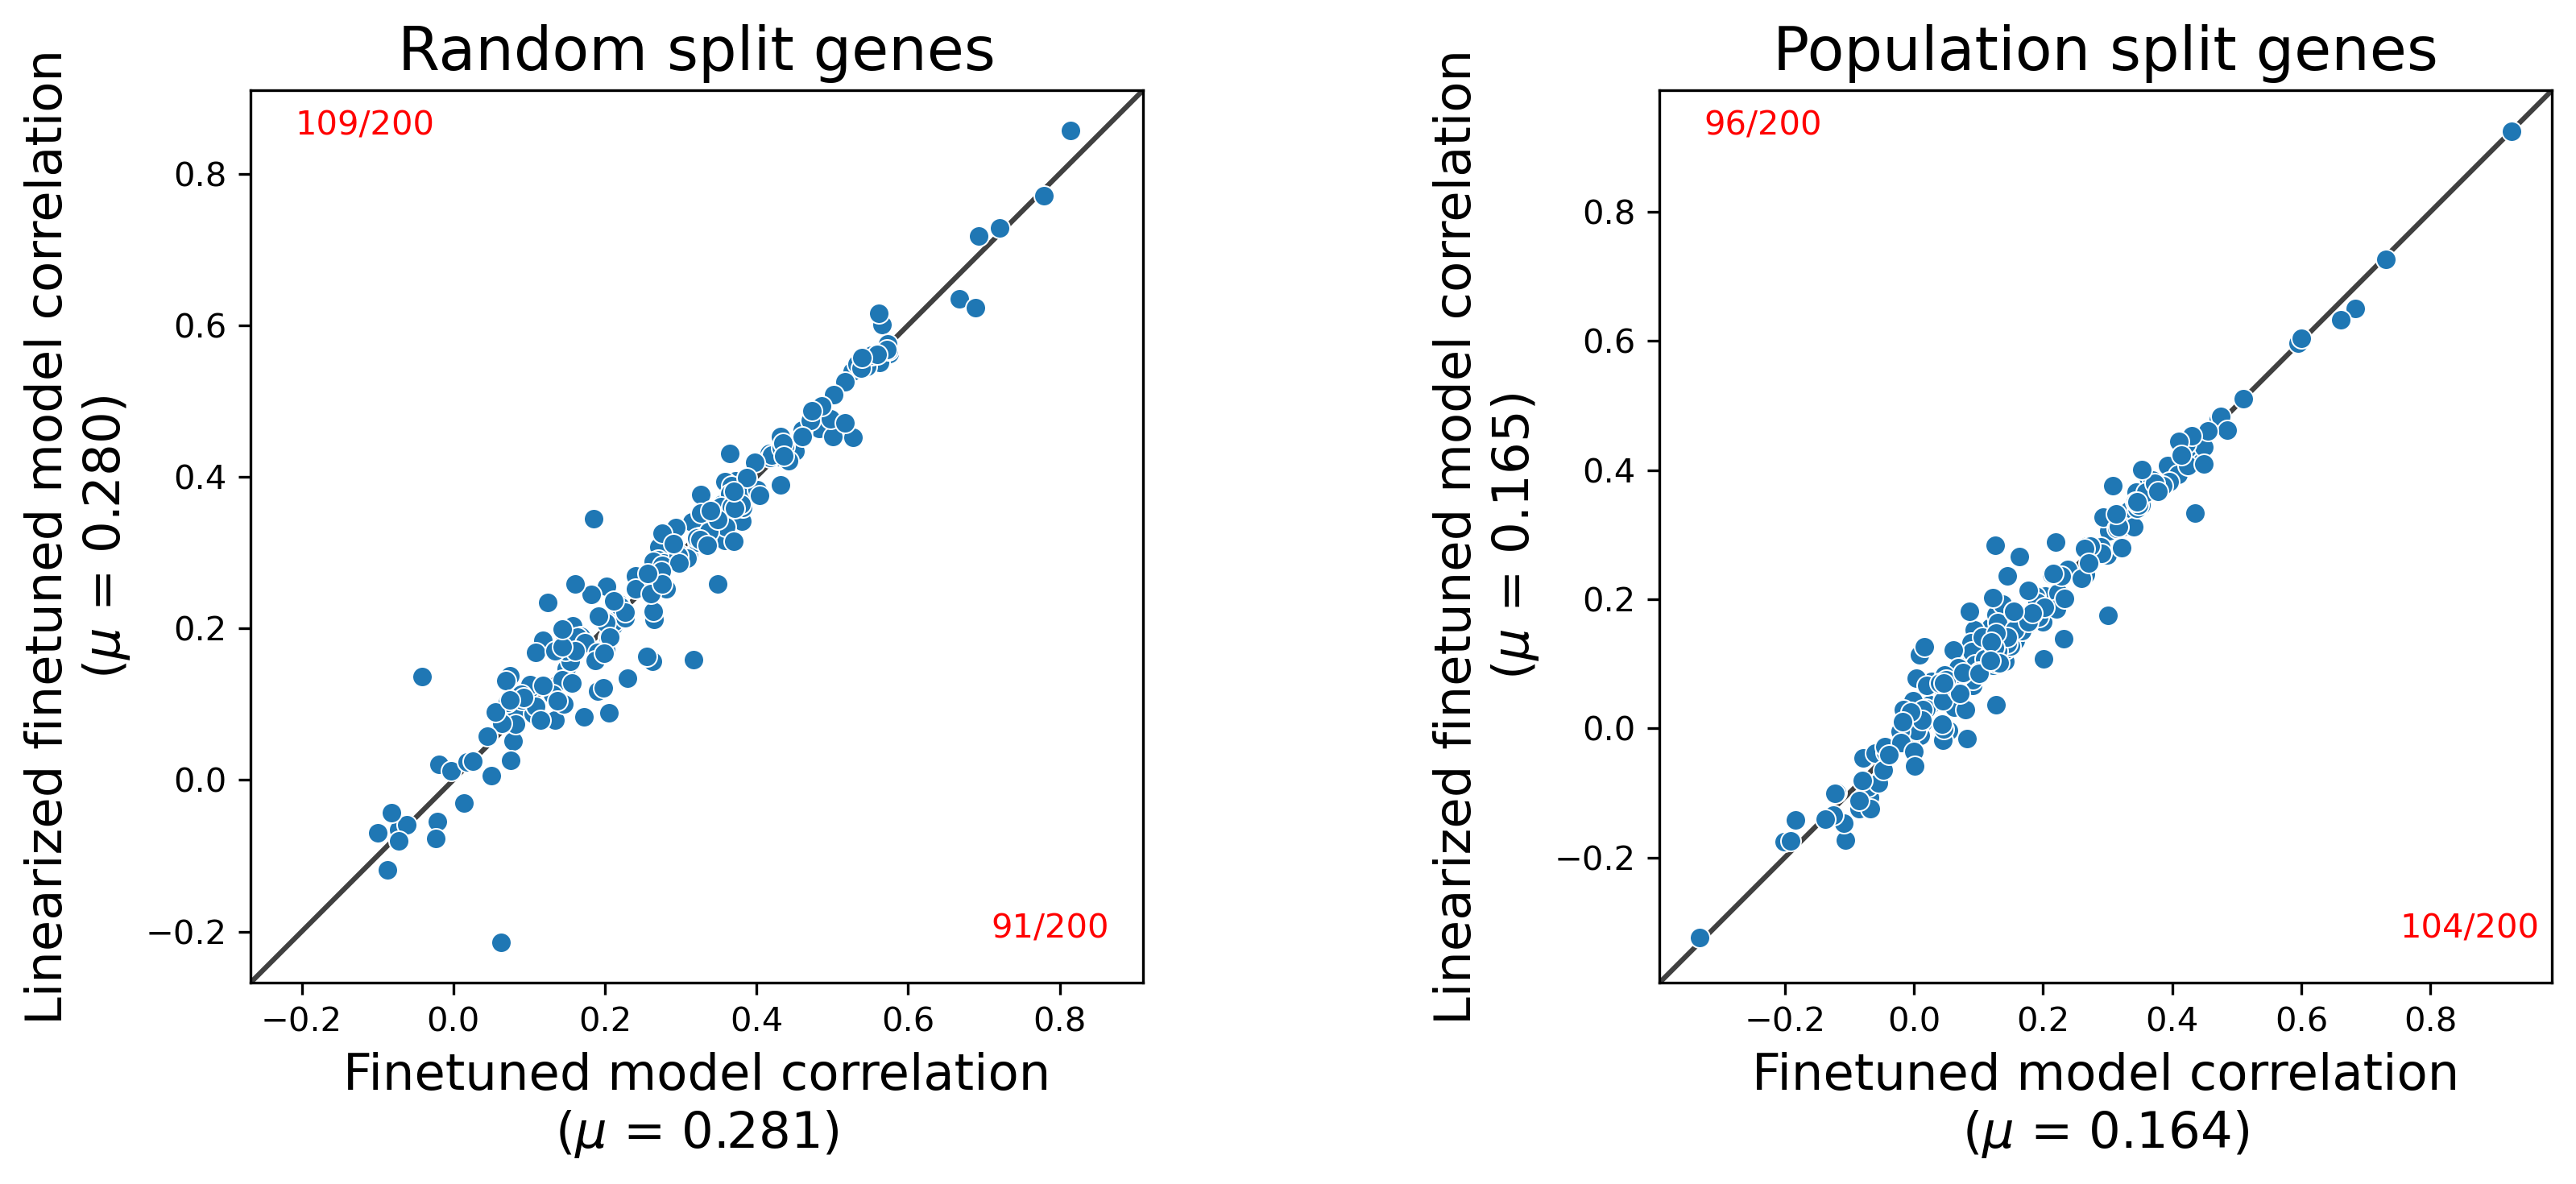

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), dpi=300)
plot_correlation_comparison(
    original_finetuned_corrs,
    linearized_finetuned_corrs,
    axs[0],
    "Finetuned model correlation",
    "Linearized finetuned model correlation",
    "Random split genes",
    random_split_genes,
)

plot_correlation_comparison(
    original_finetuned_corrs,
    linearized_finetuned_corrs,
    axs[1],
    "Finetuned model correlation",
    "Linearized finetuned model correlation",
    "Population split genes",
    population_split_genes,
)
plt.tight_layout()
plt.show()